This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow import keras

**Inspecting the data of the Jena weather dataset**

In [2]:

zip_path = tf.keras.utils.get_file(
    origin='https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip',
    extract=False)

fname = os.path.join(os.path.dirname(zip_path), 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

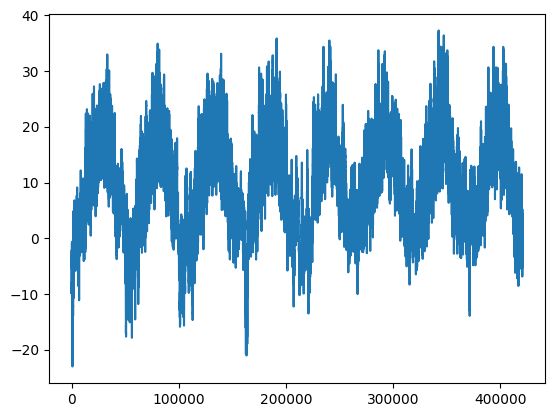

In [4]:
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

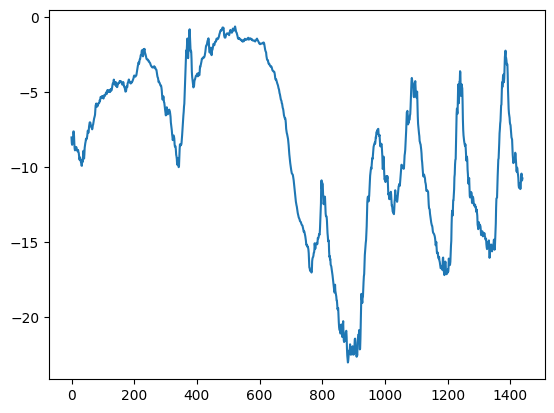

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.75 * len(raw_data)) - num_train_samples
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105113
num_test_samples: 105113


### Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model = keras.models.load_model("jena_dense.keras")

print(f"best Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"best Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 19ms/step - loss: 12.0352 - mae: 2.6868 - val_loss: 10.9638 - val_mae: 2.6113
Epoch 2/10
819/819 [==============================] - 16s 19ms/step - loss: 8.9170 - mae: 2.3455 - val_loss: 10.0419 - val_mae: 2.4920
Epoch 3/10
819/819 [==============================] - 18s 22ms/step - loss: 8.2489 - mae: 2.2597 - val_loss: 12.9951 - val_mae: 2.8412
Epoch 4/10
819/819 [==============================] - 17s 21ms/step - loss: 7.8598 - mae: 2.2066 - val_loss: 10.6151 - val_mae: 2.5577
Epoch 5/10
819/819 [==============================] - 15s 19ms/step - loss: 7.5539 - mae: 2.1639 - val_loss: 10.5301 - val_mae: 2.5463
Epoch 6/10
819/819 [==============================] - 15s 18ms/step - loss: 7.3270 - mae: 2.1326 - val_loss: 10.5636 - val_mae: 2.5493
Epoch 7/10
819/819 [==============================] - 16s 20ms/step - loss: 7.1214 - mae: 2.1019 - val_loss: 10.9735 - val_mae: 2.5994
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

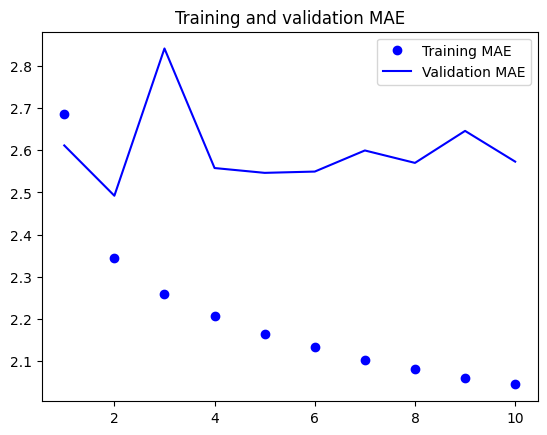

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model = keras.models.load_model("jena_conv.keras")

print(f"best Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"best Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 27s 30ms/step - loss: 20.6199 - mae: 3.5338 - val_loss: 14.6328 - val_mae: 3.0167
Epoch 2/10
819/819 [==============================] - 22s 27ms/step - loss: 14.5181 - mae: 3.0209 - val_loss: 18.2930 - val_mae: 3.4129
Epoch 3/10
819/819 [==============================] - 23s 28ms/step - loss: 13.3625 - mae: 2.8992 - val_loss: 16.6302 - val_mae: 3.2006
Epoch 4/10
819/819 [==============================] - 23s 27ms/step - loss: 12.4904 - mae: 2.8002 - val_loss: 15.1928 - val_mae: 3.0765
Epoch 5/10
819/819 [==============================] - 23s 28ms/step - loss: 11.8635 - mae: 2.7290 - val_loss: 16.7054 - val_mae: 3.2428
Epoch 6/10
819/819 [==============================] - 23s 28ms/step - loss: 11.3933 - mae: 2.6724 - val_loss: 14.4794 - val_mae: 2.9959
Epoch 7/10
819/819 [==============================] - 22s 27ms/step - loss: 11.0187 - mae: 2.6273 - val_loss: 21.3304 - val_mae: 3.6850
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model = keras.models.load_model("jena_lstm.keras")

print(f"best Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"best Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 27s 30ms/step - loss: 44.1438 - mae: 4.8574 - val_loss: 13.0457 - val_mae: 2.7366
Epoch 2/10
819/819 [==============================] - 28s 34ms/step - loss: 11.3193 - mae: 2.6122 - val_loss: 10.1826 - val_mae: 2.4652
Epoch 3/10
819/819 [==============================] - 26s 32ms/step - loss: 9.8864 - mae: 2.4546 - val_loss: 10.3653 - val_mae: 2.4807
Epoch 4/10
819/819 [==============================] - 26s 31ms/step - loss: 9.3278 - mae: 2.3796 - val_loss: 10.1053 - val_mae: 2.4571
Epoch 5/10
819/819 [==============================] - 26s 32ms/step - loss: 9.0595 - mae: 2.3427 - val_loss: 10.2165 - val_mae: 2.4624
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 8.8465 - mae: 2.3134 - val_loss: 10.4830 - val_mae: 2.4908
Epoch 7/10
819/819 [==============================] - 28s 34ms/step - loss: 8.6477 - mae: 2.2884 - val_loss: 10.4760 - val_mae: 2.4901
Epoch 8/10
819/819 [==============================] -

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [16]:
# timesteps = 100
# input_features = 32
# output_features = 64
# inputs = np.random.random((timesteps, input_features))
# state_t = np.zeros((output_features,))
# W = np.random.random((output_features, input_features))
# U = np.random.random((output_features, output_features))
# b = np.random.random((output_features,))
# successive_outputs = []
# for input_t in inputs:
#     output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
#     successive_outputs.append(output_t)
#     state_t = output_t
# final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [17]:
# num_features = 14
# inputs = keras.Input(shape=(None, num_features))
# outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [18]:
# num_features = 14
# steps = 120
# inputs = keras.Input(shape=(steps, num_features))
# outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
# print(outputs.shape)

**An RNN layer that returns its full output sequence**

In [19]:
# num_features = 14
# steps = 120
# inputs = keras.Input(shape=(steps, num_features))
# outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
# print(outputs.shape)

**Stacking RNN layers**

In [20]:
# inputs = keras.Input(shape=(steps, num_features))
# x = layers.SimpleRNN(16, return_sequences=True)(inputs)
# x = layers.SimpleRNN(16, return_sequences=True)(x)
# outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model = keras.models.load_model("jena_lstm_dropout.keras")

print(f"best Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"best Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 34s 39ms/step - loss: 28.0985 - mae: 3.8977 - val_loss: 9.7203 - val_mae: 2.4230
Epoch 2/10
819/819 [==============================] - 30s 36ms/step - loss: 14.4442 - mae: 2.9427 - val_loss: 9.3178 - val_mae: 2.3798
Epoch 3/10
819/819 [==============================] - 30s 36ms/step - loss: 13.3380 - mae: 2.8259 - val_loss: 9.5632 - val_mae: 2.4054
Epoch 4/10
819/819 [==============================] - 30s 37ms/step - loss: 12.7105 - mae: 2.7560 - val_loss: 9.8976 - val_mae: 2.4465
Epoch 5/10
819/819 [==============================] - 31s 37ms/step - loss: 12.1767 - mae: 2.6988 - val_loss: 9.6254 - val_mae: 2.4112
Epoch 6/10
819/819 [==============================] - 30s 37ms/step - loss: 11.7270 - mae: 2.6444 - val_loss: 9.5186 - val_mae: 2.3956
Epoch 7/10
819/819 [==============================] - 30s 36ms/step - loss: 11.3687 - mae: 2.6015 - val_loss: 9.4387 - val_mae: 2.3824
Epoch 8/10
819/819 [==============================] - 3

In [22]:
# inputs = keras.Input(shape=(sequence_length, num_features))
# x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
                    
print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model = keras.models.load_model("jena_stacked_gru_dropout.keras")

print(f"best Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"best Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 51s 59ms/step - loss: 24.4479 - mae: 3.6344 - val_loss: 8.9011 - val_mae: 2.2997
Epoch 2/10
819/819 [==============================] - 46s 55ms/step - loss: 13.4863 - mae: 2.8421 - val_loss: 9.0257 - val_mae: 2.3411
Epoch 3/10
819/819 [==============================] - 54s 65ms/step - loss: 12.4824 - mae: 2.7311 - val_loss: 8.8627 - val_mae: 2.3179
Epoch 4/10
819/819 [==============================] - 46s 56ms/step - loss: 11.6798 - mae: 2.6481 - val_loss: 9.0983 - val_mae: 2.3542
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 11.0208 - mae: 2.5693 - val_loss: 9.1401 - val_mae: 2.3549
Epoch 6/10
819/819 [==============================] - 46s 56ms/step - loss: 10.3440 - mae: 2.4882 - val_loss: 9.3924 - val_mae: 2.3906
Epoch 7/10
819/819 [==============================] - 45s 55ms/step - loss: 9.7769 - mae: 2.4184 - val_loss: 9.6340 - val_mae: 2.4226
Epoch 8/10
819/819 [==============================] - 45

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

model = keras.models.load_model("jena_bidirectional.keras")

print(f"best Validation MAE: {model.evaluate(val_dataset)[1]:.2f}")
print(f"best Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 48ms/step - loss: 28.1377 - mae: 3.8130 - val_loss: 10.5367 - val_mae: 2.5030
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 9.6883 - mae: 2.4354 - val_loss: 9.3367 - val_mae: 2.3671
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 8.6427 - mae: 2.2965 - val_loss: 9.7064 - val_mae: 2.4226
Epoch 4/10
819/819 [==============================] - 41s 50ms/step - loss: 8.0507 - mae: 2.2178 - val_loss: 9.9970 - val_mae: 2.4561
Epoch 5/10
819/819 [==============================] - 39s 47ms/step - loss: 7.6681 - mae: 2.1662 - val_loss: 9.7040 - val_mae: 2.4221
Epoch 6/10
819/819 [==============================] - 40s 48ms/step - loss: 7.3289 - mae: 2.1184 - val_loss: 10.0065 - val_mae: 2.4667
Epoch 7/10
819/819 [==============================] - 39s 47ms/step - loss: 7.0578 - mae: 2.0811 - val_loss: 9.7152 - val_mae: 2.4270
Epoch 8/10
819/819 [==============================] - 39s 4

### Going even further

## Summary